# Run Pycaret / lazy Predicton the the training feature hops saved eariler

In [1]:
# !pip install pycaret
!pip install pyTDC

     |████████████████████████████████| 266 kB 4.1 MB/s 
     |████████████████████████████████| 111 kB 58.4 MB/s 
     |████████████████████████████████| 1.7 MB 44.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.0 MB 28.3 MB/s 
     |████████████████████████████████| 6.8 MB 55.6 MB/s 
     |████████████████████████████████| 56 kB 4.0 MB/s 
     |████████████████████████████████| 261 kB 69.8 MB/s 
     |████████████████████████████████| 271 kB 70.5 MB/s 
     |████████████████████████████████| 14.6 MB 32.4 MB/s 
     |████████████████████████████████| 1.3 MB 56.4 MB/s 
     |████████████████████████████████| 167 kB 63.8 MB/s 
     |████████████████████████████████| 80 kB 8.9 MB/s 
     |████████████████████████████████| 62 kB 667 kB/s 
     |████████████████████████████████| 3.1 MB 52.0 MB/s 
     |███████████████████

In [1]:
from google.colab import drive
from tdc import utils
from tdc.benchmark_group import admet_group
import pandas as pd
import numpy as np
import glob
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
group = admet_group(path = 'data/')
benchmark = group.get('cyp2c9_veith')
trainingSmiles =  benchmark['train_val']['Drug']
targets = benchmark['train_val']['Y']

Found local copy...


In [3]:
import glob
%cd /content/drive/MyDrive/SpringBoard/Therapeutic Data Commons Projects/data/

/content/drive/MyDrive/SpringBoard/Therapeutic Data Commons Projects/data


In [4]:
def load_embeddings():
  file_names = glob.glob("train*")
  feature_hop_dfs = []
  for i, name in enumerate(file_names):
    try:
      df = pd.read_csv(name, index_col=0)
      feature_hop_dfs.append(df)
      print(f'read hop df {i}')
    except:
      print(f"did not read {i}")

  return feature_hop_dfs

train_feature_hop_from_drive = load_embeddings()

read hop df 0
read hop df 1
read hop df 2
read hop df 3
read hop df 4
read hop df 5
read hop df 6
read hop df 7
read hop df 8
read hop df 9
read hop df 10
read hop df 11
read hop df 12
read hop df 13
read hop df 14


In [5]:
for df in train_feature_hop_from_drive:
  print(df.shape)

(9673, 5000)
(9673, 5000)
(9673, 5000)
(9673, 5000)
(9673, 5000)
(9673, 5000)
(9673, 5000)
(9673, 5000)
(9673, 5000)
(9673, 5000)
(9673, 5000)
(9673, 5000)
(9673, 5000)
(9673, 5000)
(9673, 5000)


In [8]:
print(targets.shape)

(9673,)


# Explanation

`train_feature_hop_from_drive` contains the hop embeddings from 0 to 14. Each has shape (9673, 5000).

If I wanted to I could encode each graph as just as a 14*5000 = 70K long int vector. That vector is overwhelmingly sparse.

`targets` contains the boolean target.

Issues

1. 70_000 is a very long feature vector and due to how the color refinment algorithm works there are likly many collisions at larger hop numbers. This is since there is very likely more than 5000 possible 14 hop neighborhoods. I need a way to estimate how much information is in each of the N of the neighborhoods. 

2. I think the way to do that is through seeing the difference in performance on some kind of a 'standard model' ( not quite sure what this is ) between the un modified data and the data when I permute the targets. The average distance between them can be though of as capturing the amount of information in the features at that hop.


I got this idea from a blog post on Numerai https://forum.numer.ai/t/feature-selection-by-marcos-lopez-de-prado/3170 

He cites: 
Marcos Lopez de Prado describes the “Mean Descreas Accuracy” algorithm in his book “Advances in Financial Machine Learning”


In [9]:
from sklearn.metrics import precision_recall_curve, auc

def compute_auprc(y_true, y_preds):
    # https://stats.stackexchange.com/questions/157012/area-under-precision-recall-curve-auc-of-pr-curve-and-average-precision-ap
    precision, recall, thresholds = precision_recall_curve(y_true, y_preds)
    area = auc(recall, precision)
    return area

In [23]:
import lightgbm as lgb
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split

def compute_impact_of_permuting_training_features(feature_df):
  X = feature_df
  y = targets

  unpermuted_scores = []
  permuted_scores = []

  for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=i)
    model = lgb.LGBMClassifier().fit(X_train, y_train)
    unpermuted_score = compute_auprc(y_test, model.predict(X_test))
    unpermuted_scores.append(unpermuted_score)

    y_train = np.random.permutation(y_train)
    model = lgb.LGBMClassifier().fit(X_train, y_train)
    permuted_score = compute_auprc(y_test, model.predict(X_test))
    permuted_scores.append(permuted_score)

  average_differnce = np.mean(unpermuted_scores) - np.mean(permuted_score)
  return average_differnce


hop_df_importance = dict()

for index, feature_df in enumerate(train_feature_hop_from_drive):
  hop_df_importance[f'hop_df_average_difference{index}'] =  compute_impact_of_permuting_training_features(feature_df)
  print(f'computed importance for hop {index}')


hop_df_importance

computed importance for hop 0
computed importance for hop 1
computed importance for hop 2
computed importance for hop 3
computed importance for hop 4
computed importance for hop 5
computed importance for hop 6
computed importance for hop 7
computed importance for hop 8
computed importance for hop 9
computed importance for hop 10
computed importance for hop 11
computed importance for hop 12
computed importance for hop 13
computed importance for hop 14


{'hop_df_average_difference0': 0.4065372285133184,
 'hop_df_average_difference1': 0.4117582555936721,
 'hop_df_average_difference10': 0.05665051823944589,
 'hop_df_average_difference11': 0.06374144601243831,
 'hop_df_average_difference12': 0.042870409481214955,
 'hop_df_average_difference13': -0.00956144761113259,
 'hop_df_average_difference14': 0.01883465375567217,
 'hop_df_average_difference2': 0.35762640931093476,
 'hop_df_average_difference3': 0.3014101915597639,
 'hop_df_average_difference4': 0.27754150214946904,
 'hop_df_average_difference5': 0.20345432747891345,
 'hop_df_average_difference6': 0.2098765458103774,
 'hop_df_average_difference7': 0.1444609868145013,
 'hop_df_average_difference8': 0.11807442718967898,
 'hop_df_average_difference9': 0.1297404230383652}

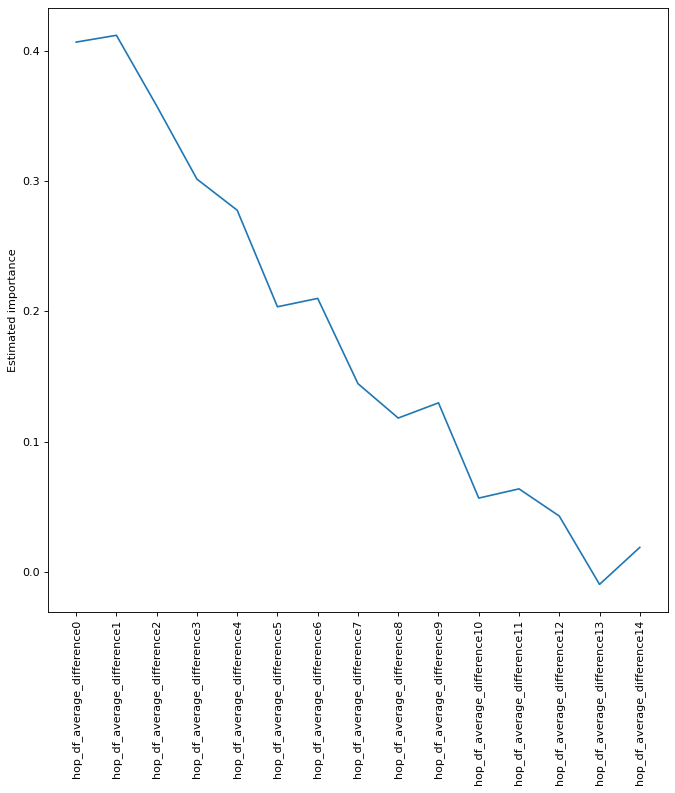

In [25]:
import matplotlib.pyplot as plt

hop_importance_df = pd.DataFrame.from_dict(hop_df_importance.items())
hop_importance_df = hop_importance_df.set_index(0)

from matplotlib.pyplot import figure
figure(figsize=(10, 10), dpi=80)

plt.plot(hop_importance_df)
plt.xticks(rotation=90)
plt.ylabel('Estimated importance')
plt.show()

It looks like the most important hops are towards the start and appear to level out at only slightly better than random after hop number 6. This is an intuitive method but I think it is good enough for now.